# Description
* **In this notebook, we will see the change in concentration of Formaldehyde(HCHO) for a Region around Pune,India from the time before the covid-19 restrictions, and during the restrictions**

**About Formaldehyde**
* **Formaldehyde is an intermediate gas in almost all oxidation chains of non-methane volatile organic compounds (NMVOC), leading eventually to CO2**
* **HCHO concentrations in the boundary layer can be directly related to the release of short-lived hydrocarbons, which mostly cannot be observed directly from space.**
* **The major HCHO source in the remote atmosphere is CH4 oxidation**
* **The oxidation of higher NMVOCs emitted from vegetation, fires, traffic and industrial sources results in important and localized enhancements of the HCHO levels.**


# **Imports**

In [103]:
import ee
import folium 
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from scipy import optimize
from folium.plugins import MarkerCluster,HeatMap
import branca


%matplotlib inline

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi']=200

# **Helper Functions**

In [3]:
#helper functions

def get_df(img_collection_info,
           bands):
    '''get a dataframe of values for the given Bands'''
    
    
    df = pd.DataFrame(img_collection_info)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *bands]].dropna()

    # Convert the data to numeric values.
    for band in bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    #lat-long of point as location
    df['location']=df.apply(lambda x : (x['latitude'],x['longitude']),axis=1)
    
    
    # Keep the columns of interest.
    df = df[['time','datetime','location',  *bands]]

    return df
    
def mean_value(df,band):
    '''Taking the mean value for a band for each groupby (by date) object for that region,so that we have a mean value of given band for that region'''
    
    
    #mean value for particular instance of time
    mean_val_df=df.groupby('datetime').agg({f'{band}':['mean','max']})
    mean_val_df.reset_index(inplace=True)
    
    #sortby date
    mean_val_df.sort_values(by='datetime',inplace=True)
    
    return mean_val_df


def get_range_df(df,
                date_col,
                start_date,
                end_date):
    '''get a dataframe bounded by start and end date'''
    
    return df[(df[date_col]>start_date)&(df[date_col]<end_date)]


#plotting

def plot_all_values(df,
                    df2,
                    band):
    '''Plot all the given values,
    df: Urban Dataset
    df2:rural Dataset'''
    
    fig,ax=plt.subplots(figsize=(16,8))
    
    ax.plot(df.datetime,
            df[band]['mean'],
            color='r',
            lw=0.5,
            label='Urban')

    ax.plot(df2.datetime,
            df2[band]['mean'],
            color='b',
            lw=0.5,
            label='Rural')

    plt.title(f'{band} in Pune Region')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(f'{band} (mol/m^2)')
    plt.show()
    
    
    
def plot_monthwise(df,
                  df2,
                  band):
    '''plot seasonal trend in concentration of specified band
    df: urban data points
    df2: rural data points
    band : band in question'''
        
    #mean band level for each month 
    urban=df.groupby(df.datetime.dt.month).agg({(f'{band}','mean'):'mean'})
    urban.index.name='Months'
    urban.reset_index(inplace=True)
    
    
    rural=df2.groupby(df.datetime.dt.month).agg({(f'{band}','mean'):'mean'})
    rural.index.name='Months'
    rural.reset_index(inplace=True)
    
    
    
    comb=urban.merge(rural,on='Months',how='inner')
    comb.rename(columns={f'{band}_x':'Urban',f'{band}_y':f'Rural'},inplace=True)
    comb.set_index('Months',inplace=True)
    comb.plot(figsize=(16,8))
    
    
    plt.title(f'Monthwise mean {band}')
    plt.xlabel('Month of the year')
    plt.ylabel(f'Monthwise Mean {band} (mol/m^2)')
    plt.show()

    
def plot_comparison_plots(df,
                          df2,
                          band,
                          Title):
    '''PLOT COMPARISON PLOTS for Before and during Pandemic
    df: NO2 levels during pre Pandemic study period
    df2:NO2 During Pandemic study period
    '''
    fig,ax=plt.subplots(2,1,figsize=(16,8))
    print(f'{Title}')
    
    
    ax[0].plot(df.datetime,
            df[band]['mean'],
            color='r',
            lw=2)
    ax[0].set_title('Before Covid-19')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel(f'{band} (mol/m^2)')
    
    

    ax[1].plot(df2.datetime,
            df2[band]['mean'],
            color='g',
            lw=2)
    ax[1].set_title('During Covid-19')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel(f'{band} (mol/m^2)')
    
    plt.tight_layout()
    
    #saving image
    fig.savefig(f'{Title}.jpg')
    plt.show()
    
def percent_change(df,df2,band):
    '''calculate % change in band value for old window and new window '''
    mean_pre   = df[f'{band}']['mean'].mean()
    mean_during= df2[f'{band}']['mean'].mean()
        
    diff=mean_pre-mean_during
    percent_change=(diff/mean_pre)*100
    
    return percent_change

**Bounding dates used for study**

In [4]:
# The dates to be used for study


pre_pandemic={
    'start_date':'2019-03-01',
    'end_date'  :'2019-07-01'
}

pandemic={
    'start_date':'2020-03-01',
    'end_date'  :'2020-07-01'
}

# **Authenticate and Inititalize Earth Engine**

In [7]:
ee.Authenticate()
ee.Initialize()

In [8]:
# loading area of interest coordinates

with open('../input/pune-coordinates/bounding_polygons.pkl','rb') as f:
    coord_dict=pickle.load(f)

aoi=ee.geometry.Geometry.Polygon(list(coord_dict['pune'].values()))
aoi_rural=ee.geometry.Geometry.Polygon(list(coord_dict['pune_rural'].values()))
aoi_urban=ee.geometry.Geometry.Polygon(list(coord_dict['pune_urban'].values()))

In [150]:
'''Description : Tropospheric HCHO column number density.(mol/m2)'''
CO=ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_HCHO').filterBounds(aoi).select('tropospheric_HCHO_column_number_density')

print('Number of Images in collection  are {}'.format(CO.size().getInfo()))

Number of Images in collection  are 14096


In [151]:
# get Image INFO

# sample a few locations for which data is to be queried

#Central Areas of Pune and PCMC
pune_central=CO.getRegion(geometry=aoi_urban,
                          scale=3000,
                          ).getInfo()


# Some rural areas of Pune
pune_rural=CO.getRegion(geometry=aoi_rural,
                          scale=5000,
                          ).getInfo()

# Area under study

In [152]:
df_urban=get_df(pune_central,
                ['tropospheric_HCHO_column_number_density'])

df_rural=get_df(pune_rural,
                ['tropospheric_HCHO_column_number_density'])


m1=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=12,min_zoom=9)

HeatMap(data=df_urban['location'],
                       radius=10,
                       opacity=.05,
                       name='Urban').add_to(m1)

HeatMap(data=df_rural['location'],
                       radius=10,
                       opacity=.05,
                       name='rural').add_to(m1)


m1

In [153]:

print('Number of Data Points in Urban Study {} \n Number of Data Points in Rural Study {}'.format(len(df_urban),len(df_rural)))

Number of Data Points in Urban Study 23565 
 Number of Data Points in Rural Study 35943


# Getting Timeseries data for CO concentrations


In [154]:
# Dataset for Urban Pune CO density

urban_hcho=mean_value(df_urban,
                     band='tropospheric_HCHO_column_number_density')
#saving urban 
urban_hcho.to_csv('urban_hcho.csv',index=False)

# Rural  Dataset
rural_hcho=mean_value(df_rural,
                    band='tropospheric_HCHO_column_number_density')
#saving 
rural_hcho.to_csv('rural_hcho.csv',index=False)

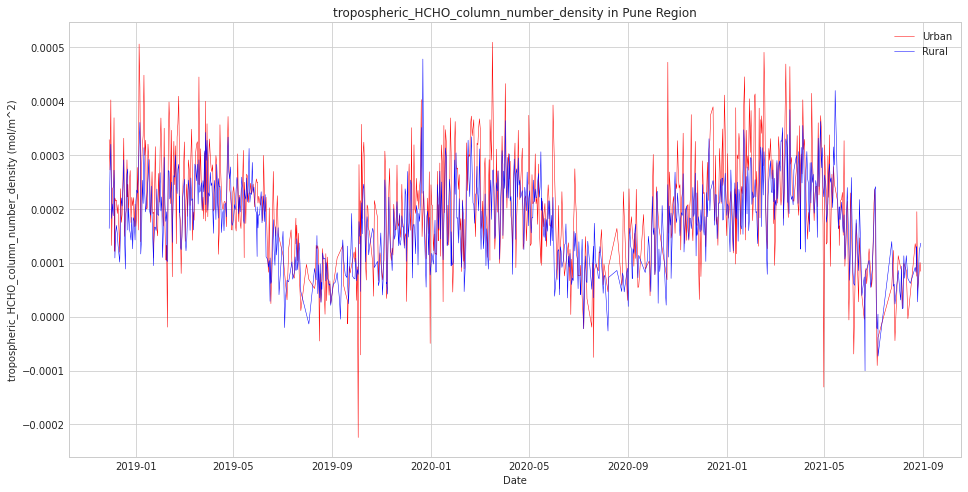

In [155]:
plot_all_values(df=urban_hcho,
               df2=rural_hcho,
               band='tropospheric_HCHO_column_number_density')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


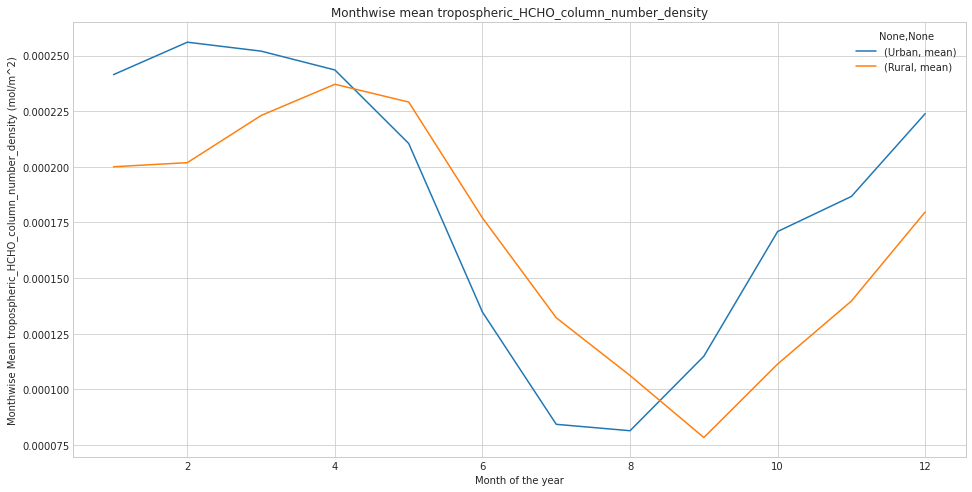

In [156]:
plot_monthwise(df=urban_hcho,
               df2=rural_hcho,
               band='tropospheric_HCHO_column_number_density')

# Effects of Pandemic restrictions on CO emissions


In [157]:
#PREPANDEMIC URBAN AND RURAL CO DENSITY DATA

#urban
prepandemic_ur=get_range_df(df=urban_hcho,
                            date_col='datetime',
                           start_date=pre_pandemic['start_date'],
                           end_date=pre_pandemic['end_date'])

#rural
prepandemic_rur=get_range_df(df=rural_hcho,
                            date_col='datetime',
                           start_date=pre_pandemic['start_date'],
                           end_date=pre_pandemic['end_date'])


#PANDEMIC URBAN AND RURAL CO DENSITY DATA

#urban
pandemic_ur=get_range_df(df=urban_hcho,
                        date_col='datetime',
                        start_date=pandemic['start_date'],
                        end_date = pandemic['end_date'])

#rural

pandemic_rur=get_range_df(df=rural_hcho,
                         date_col='datetime',
                         start_date=pandemic['start_date'],
                         end_date=pandemic['end_date'])

Formaldehyde Concentration over Urban Pune


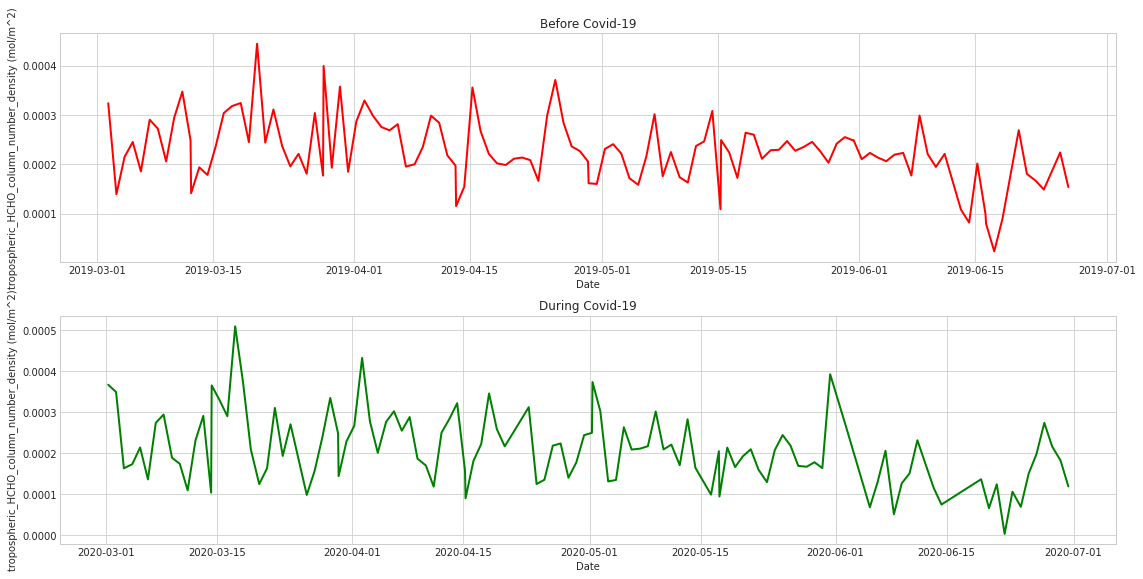

In [158]:
# CHange in CO over Urban areas
plot_comparison_plots(df=prepandemic_ur,
                     df2=pandemic_ur,
                     band='tropospheric_HCHO_column_number_density',
                     Title='Formaldehyde Concentration over Urban Pune')

Formaldehyde Concentration over Rural Pune


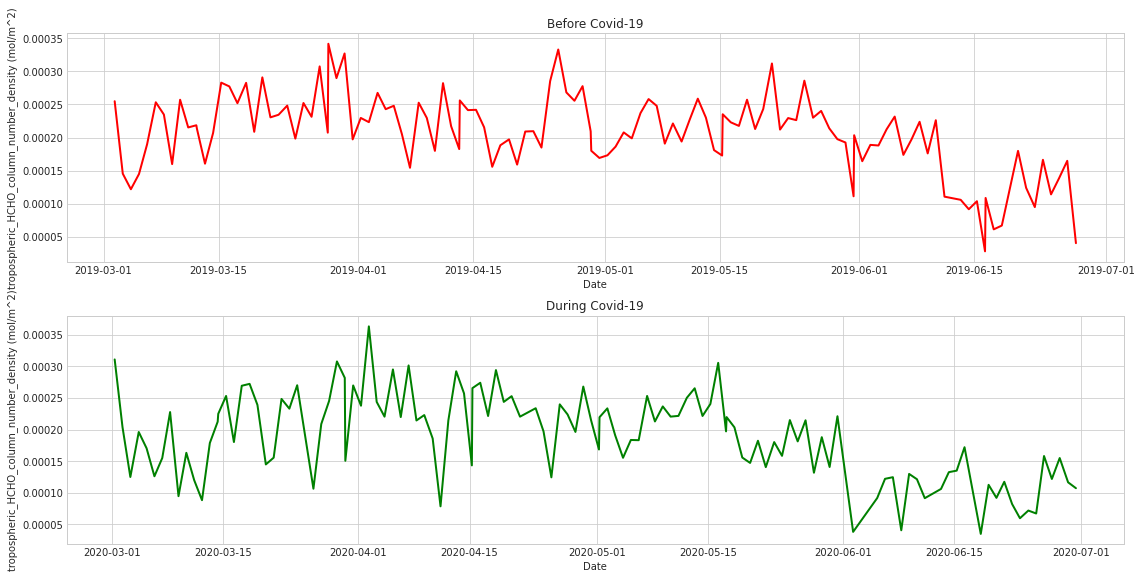

In [159]:
# CHange in CO over Rural areas
plot_comparison_plots(df=prepandemic_rur,
                     df2=pandemic_rur,
                     band='tropospheric_HCHO_column_number_density',
                     Title='Formaldehyde Concentration over Rural Pune')

# Percent change in value of HCHO


In [160]:
print('Mean % drop in Urban CO level during pandemic restrictions {}'.format(percent_change(df=prepandemic_ur,
                                                                                             df2=pandemic_ur,
                                                                                            band='tropospheric_HCHO_column_number_density')))
print('Mean % drop in Rural CO level during pandemic restrictions {}'.format(percent_change(df=prepandemic_rur,
                                                                                             df2=pandemic_rur,
                                                                                            band='tropospheric_HCHO_column_number_density')))

Mean % drop in Urban CO level during pandemic restrictions 7.522044426280723
Mean % drop in Rural CO level during pandemic restrictions 9.07833758427414


# Visualize Mean change over study period


In [162]:
#visualization parameters
viz_param={
    'min':0.00001, 'max': 0.0005,
    'palette':['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

In [163]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# PrePandemic (April 2019 to June 2019)


In [164]:
M2=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=10,min_zoom=9)


#adding NO2 density layer
M2.add_ee_layer(ee_image_object=ee.Image(CO.filterDate(pre_pandemic['start_date'],pre_pandemic['end_date']).mean()).clip(aoi),
               vis_params=viz_param,
               name='HCHO Density (April-June 2019)')
print('April 2019 to June 2019')

#add tile control
M2.add_child(folium.LayerControl())
M2.save('Prepandemic_HCHO.html')

M2

April 2019 to June 2019



# During Pandemic (April 2020 to June 2020)


In [165]:
M3=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=10,min_zoom=9)


#adding NO2 density layer
M3.add_ee_layer(ee_image_object=ee.Image(CO.filterDate(pandemic['start_date'],pandemic['end_date']).mean()).clip(aoi),
               vis_params=viz_param,
               name='HCHO Density (April-June 2020)')
print('April 2020 to June 2020')


#add tile control
M3.add_child(folium.LayerControl())

M3.save('pandemic_HCHO.html')

M3

April 2020 to June 2020
